# ScRNA-Seq from [Baron](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE84133)

In [1]:
# Import packages
import scanpy as sc
import pandas as pd
import numpy as np
from functions import data_preprocessing as dp

In [2]:
path = '../../../../data/raw/data_for_evaluating_cell_type_annotation/Baron/'

files = ['GSM2230757_human1_umifm_counts.csv', 
         'GSM2230758_human2_umifm_counts.csv',
         'GSM2230759_human3_umifm_counts.csv',
         'GSM2230760_human4_umifm_counts.csv']

adata_files = []

for idx, file in enumerate(files):
    df = pd.read_csv(path + file)

    X = np.array(df.iloc[:,3:])
    Y = df.iloc[:,2].to_list()
    sample_ID = df.iloc[:,0].to_list()
    gene_symbols = df.columns[3:].to_list()

    adata = sc.AnnData(X=X)
    adata.index = gene_symbols
    adata.var_names = gene_symbols
    adata.obs["cell_type"] = Y
    adata.obs["patientID"] = [f"Patient_{idx}"]*len(Y)

    adata_files.append(adata)

adata = adata_files[0].concatenate(adata_files[1:], batch_key='patientID', join='outer', index_unique=None)
adata.obs["patientID"] = ["{}{}".format(prefix, id) for prefix, id in zip(["Patient_"]*len(adata.obs["patientID"]), adata.obs["patientID"].to_list())]

# Checking for duplicate genes
duplicate_genes = adata.var_names[adata.var_names.duplicated()]
if not duplicate_genes.empty:
    print(f"Duplicate genes found: {duplicate_genes}")

c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata.obs["patientID"]

0       Patient_0
1       Patient_0
2       Patient_0
3       Patient_0
4       Patient_0
          ...    
1298    Patient_3
1299    Patient_3
1300    Patient_3
1301    Patient_3
1302    Patient_3
Name: patientID, Length: 8569, dtype: object

In [4]:
adata.var.head()

""
A1BG
A1CF
A2M
A2ML1
A4GALT


In [5]:
adata

AnnData object with n_obs × n_vars = 8569 × 20125
    obs: 'cell_type', 'patientID'

## Preprocessing

In [6]:
# Add QC metrics to adata
adata = dp.QC().QC_metric_calc(adata)
print(adata.obs)

               cell_type  patientID  n_counts  log_n_counts  n_genes  \
0                 acinar  Patient_0     22412     10.017396     3526   
1                 acinar  Patient_0     27953     10.238316     4201   
2                 acinar  Patient_0     16895      9.734832     2119   
3                 acinar  Patient_0     19300      9.867912     2956   
4                 acinar  Patient_0     15067      9.620329     2715   
...                  ...        ...       ...           ...      ...   
1298  activated_stellate  Patient_3      2100      7.650169     1055   
1299               alpha  Patient_3      2022      7.612337     1007   
1300                beta  Patient_3      2197      7.695303      942   
1301                beta  Patient_3      2153      7.675082     1031   
1302              ductal  Patient_3      2463      7.809541      985   

      log_n_genes  pct_counts_in_top_20_genes  mt_frac  ribo_frac  hem_frac  
0        8.168203                    0.395056      0.0   

In [7]:
#Filter genes:
print('Number of genes before filtering: {:d}'.format(adata.n_vars))

# Min "expression_limit" cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f'Number of genes after filtering so theres min {20} unique cells per gene: {adata.n_vars}')

Number of genes before filtering: 20125
Number of genes after filtering so theres min 20 unique cells per gene: 14322


c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Normalize

In [8]:
norm_qc_adata = dp.log1p_normalize(adata)
del norm_qc_adata.layers['pp_counts']

In [9]:
norm_qc_adata

AnnData object with n_obs × n_vars = 8569 × 14322
    obs: 'cell_type', 'patientID', 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'ribo_frac', 'hem_frac', 'size_factors'
    var: 'n_cells'
    layers: 'log1p_counts'

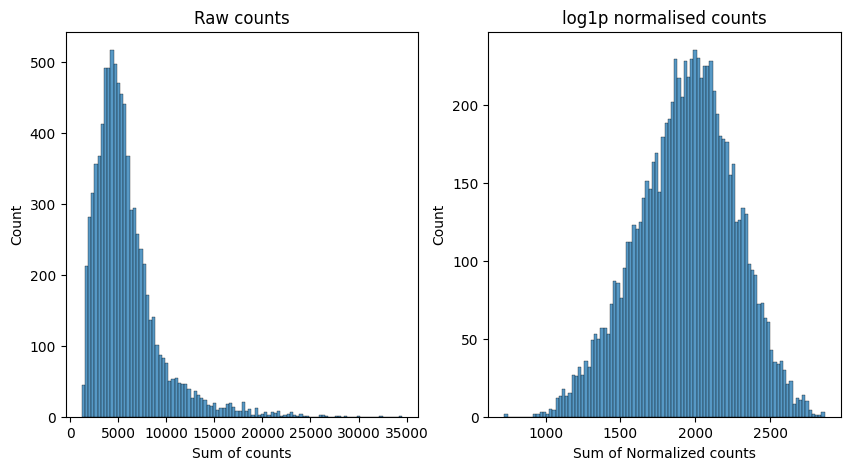

In [10]:
# Visualize counts before and after normalization
dp.EDA().VisualizeNormalization(norm_qc_adata)

In [11]:
# Change data type
norm_qc_adata.X = norm_qc_adata.X.astype(np.float32)

In [12]:
# Download normalized count matrix
norm_qc_adata.write('../../../../data/processed/data_for_evaluating_cell_type_annotation/Baron.h5ad')